In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the datasets
calls = pd.read_csv('callsf0d4f5a.csv')
customers = pd.read_csv('customers2afd6ea.csv')
reasons = pd.read_csv('reason18315ff.csv')
sentiment_statistics = pd.read_csv('sentiment_statisticscc1e57a.csv')


In [3]:
#  Merge the datasets
merged_data = pd.merge(calls, reasons, on='call_id')
merged_data = pd.merge(merged_data, sentiment_statistics, on=['call_id', 'agent_id'])
merged_data = pd.merge(merged_data, customers[['customer_id', 'elite_level_code']], on='customer_id', how='left')


In [4]:
# Handle missing values
merged_data['elite_level_code'].fillna(merged_data['elite_level_code'].median(), inplace=True)
merged_data['agent_tone'].fillna(merged_data['agent_tone'].mode()[0], inplace=True)
merged_data['customer_tone'].fillna(merged_data['customer_tone'].mode()[0], inplace=True)
merged_data['average_sentiment'].fillna(merged_data['average_sentiment'].median(), inplace=True)


In [5]:
#  Feature Engineering
# Create 'call_duration' and 'wait_time'
merged_data['call_start_datetime'] = pd.to_datetime(merged_data['call_start_datetime'])
merged_data['agent_assigned_datetime'] = pd.to_datetime(merged_data['agent_assigned_datetime'])
merged_data['call_end_datetime'] = pd.to_datetime(merged_data['call_end_datetime'])

merged_data['call_duration'] = (merged_data['call_end_datetime'] - merged_data['call_start_datetime']).dt.total_seconds() / 60
merged_data['wait_time'] = (merged_data['agent_assigned_datetime'] - merged_data['call_start_datetime']).dt.total_seconds() / 60


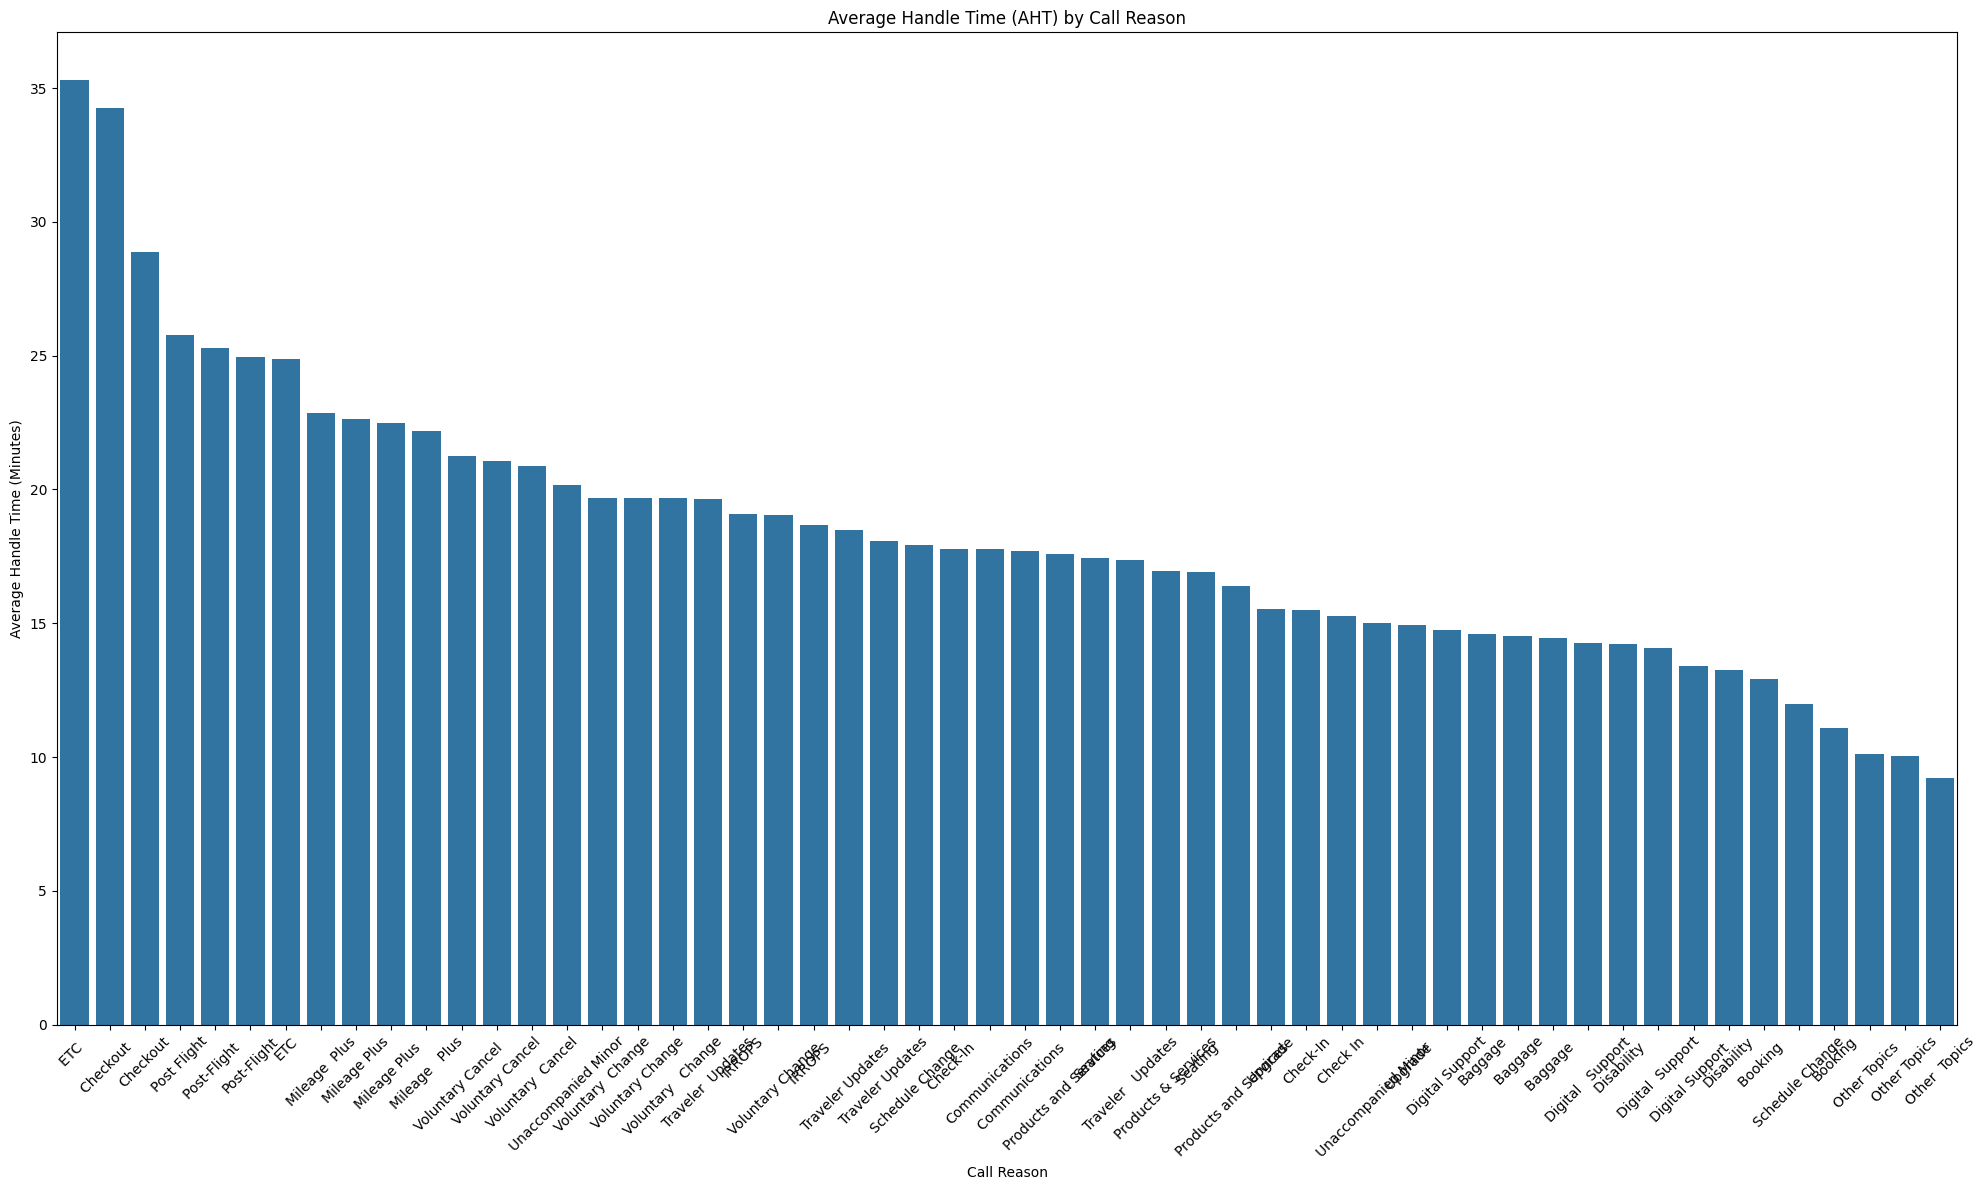

In [6]:
# Average Handle Time (AHT) by Call Reason
aht_by_reason = merged_data.groupby('primary_call_reason')['call_duration'].mean().sort_values(ascending=False)

# Plot: AHT by Call Reason
plt.figure(figsize=(20, 12))
sns.barplot(x=aht_by_reason.index, y=aht_by_reason.values)
plt.title("Average Handle Time (AHT) by Call Reason")
plt.xlabel("Call Reason")
plt.ylabel("Average Handle Time (Minutes)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

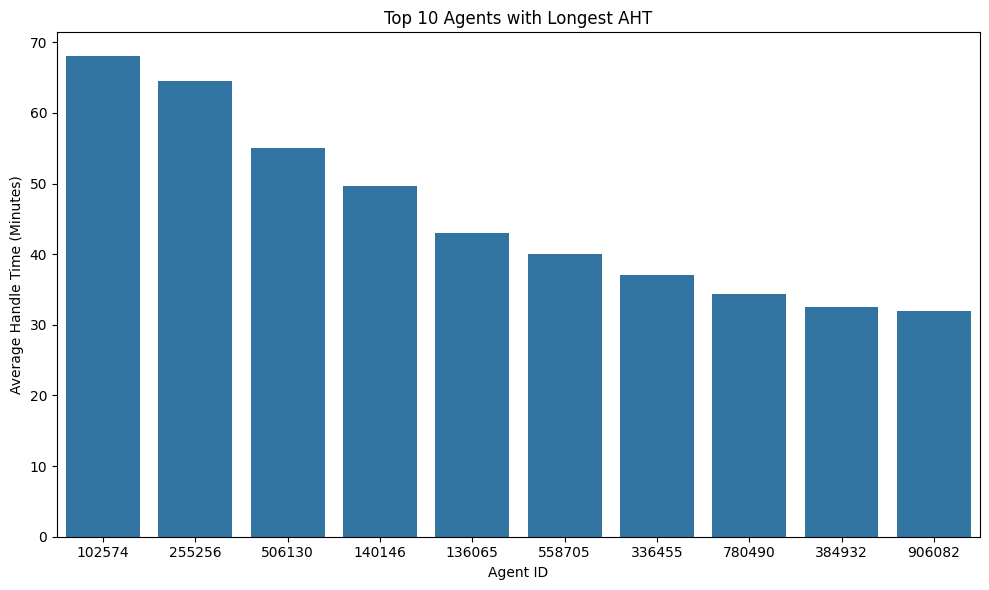

In [7]:
# AHT Analysis by Agent Performance
aht_by_agent = merged_data.groupby('agent_id')['call_duration'].mean().sort_values(ascending=False).head(10)

# Plot: AHT by Agent Performance (Top 10 agents with longest AHT)
plt.figure(figsize=(10, 6))
sns.barplot(x=aht_by_agent.index.astype(str), y=aht_by_agent.values)
plt.title("Top 10 Agents with Longest AHT")
plt.xlabel("Agent ID")
plt.ylabel("Average Handle Time (Minutes)")
plt.tight_layout()
plt.show()

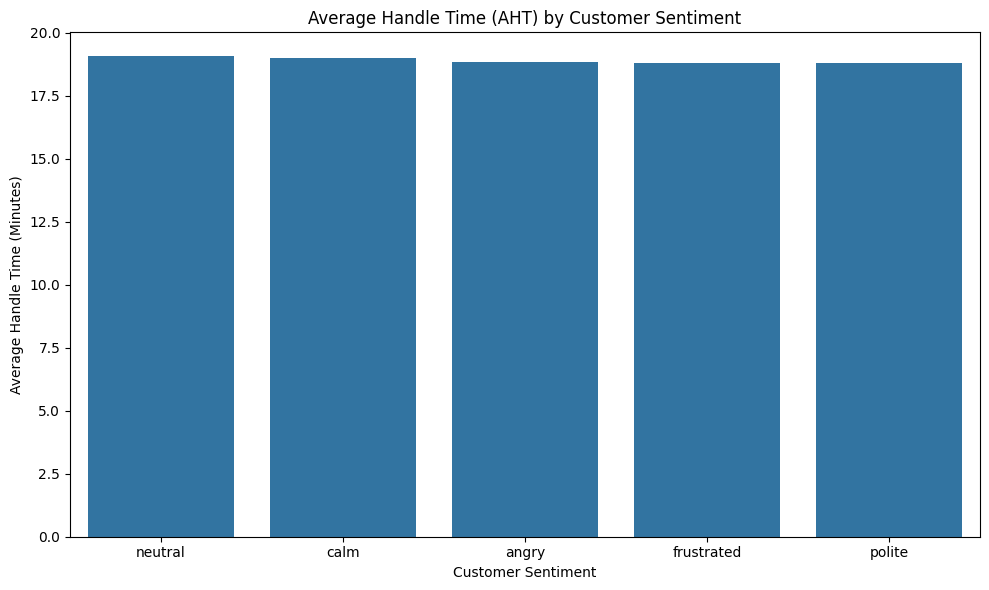

In [8]:
# AHT Analysis by Customer Sentiment
aht_by_sentiment = merged_data.groupby('customer_tone')['call_duration'].mean().sort_values(ascending=False)

# Plot: AHT by Customer Sentiment
plt.figure(figsize=(10, 6))
sns.barplot(x=aht_by_sentiment.index, y=aht_by_sentiment.values)
plt.title("Average Handle Time (AHT) by Customer Sentiment")
plt.xlabel("Customer Sentiment")
plt.ylabel("Average Handle Time (Minutes)")
plt.tight_layout()
plt.show()

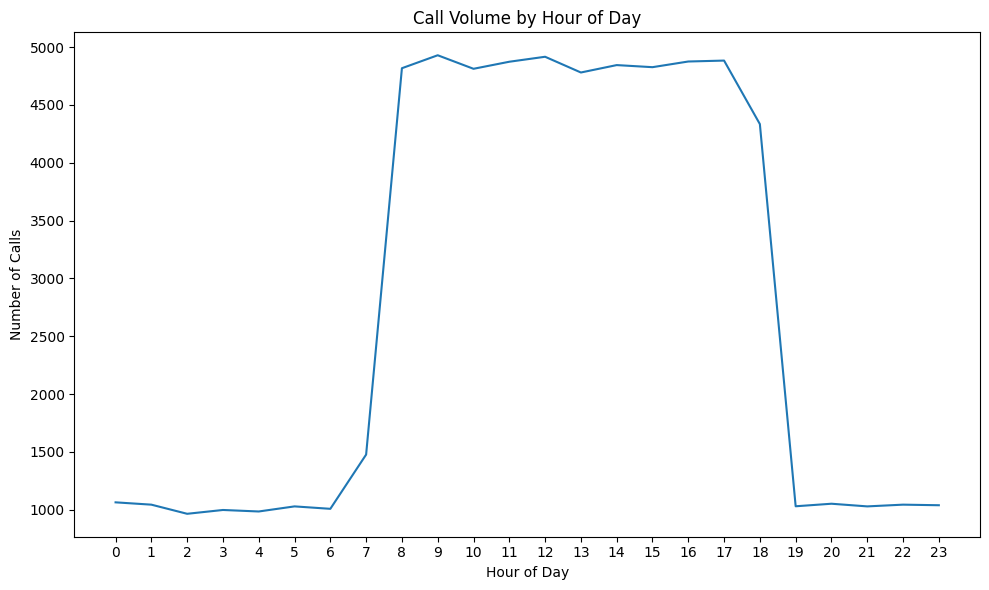

In [9]:
# AST Analysis: Investigate call volume and customer behavior during peak times

# Analyze call volumes by hour of the day to detect peak times
merged_data['call_hour'] = merged_data['call_start_datetime'].dt.hour
call_volume_by_hour = merged_data.groupby('call_hour')['call_id'].count()

# Plot: Call Volume by Hour of Day
plt.figure(figsize=(10, 6))
sns.lineplot(x=call_volume_by_hour.index, y=call_volume_by_hour.values)
plt.title("Call Volume by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Calls")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

In [10]:
# Step 7: Correlations for AST and AHT

# Correlation between customer sentiment and AHT
correlation_duration_sentiment = merged_data['call_duration'].corr(merged_data['average_sentiment'])

# Correlation between customer sentiment and AST (wait_time)
correlation_wait_sentiment = merged_data['wait_time'].corr(merged_data['average_sentiment'])

# Display Correlation Insights
correlation_insights = {
    "Correlation between AHT and Sentiment": correlation_duration_sentiment,
    "Correlation between AST and Sentiment": correlation_wait_sentiment
}

print("Correlation Insights:")
print(correlation_insights)

Correlation Insights:
{'Correlation between AHT and Sentiment': -0.06711953092676329, 'Correlation between AST and Sentiment': 0.041297354224336426}


In [11]:
# Step 8: Verify no missing values
missing_values = merged_data.isnull().sum()
print("Missing Values After Cleaning:")
print(missing_values)

Missing Values After Cleaning:
call_id                    0
customer_id                0
agent_id                   0
call_start_datetime        0
agent_assigned_datetime    0
call_end_datetime          0
call_transcript            0
primary_call_reason        0
agent_tone                 0
customer_tone              0
average_sentiment          0
silence_percent_average    0
elite_level_code           0
call_duration              0
wait_time                  0
call_hour                  0
dtype: int64


In [12]:
# Step 1: Average Handle Time (AHT) and Average Speed to Answer (AST)
# Calculate AHT and AST
merged_data['call_start_datetime'] = pd.to_datetime(merged_data['call_start_datetime'])
merged_data['agent_assigned_datetime'] = pd.to_datetime(merged_data['agent_assigned_datetime'])
merged_data['call_end_datetime'] = pd.to_datetime(merged_data['call_end_datetime'])

merged_data['call_duration'] = (merged_data['call_end_datetime'] - merged_data['call_start_datetime']).dt.total_seconds() / 60
merged_data['wait_time'] = (merged_data['agent_assigned_datetime'] - merged_data['call_start_datetime']).dt.total_seconds() / 60

# Average Handle Time (AHT)
aht = merged_data['call_duration'].mean()

# Average Speed to Answer (AST)
ast = merged_data['wait_time'].mean()

# Step 2: Customer Sentiment Analysis
sentiment_analysis = merged_data.groupby('customer_tone').agg(
    count=('customer_tone', 'size'),
    average_sentiment=('average_sentiment', 'mean'),
    average_call_duration=('call_duration', 'mean')
).reset_index()

# Step 3: Call Reasons Distribution
call_reasons_distribution = merged_data['primary_call_reason'].value_counts().reset_index()
call_reasons_distribution.columns = ['primary_call_reason', 'count']

# Step 4: Elite Customer Analysis
elite_customer_analysis = merged_data.groupby('elite_level_code').agg(
    total_calls=('call_id', 'size'),
    avg_call_duration=('call_duration', 'mean'),
    avg_wait_time=('wait_time', 'mean')
).reset_index()

# Step 5: Correlation between Average Sentiment and Call Duration
correlation_sentiment_duration = merged_data['call_duration'].corr(merged_data['average_sentiment'])

# Step 6: Percentage of Escalated Calls (assumed escalated calls have a specific tag, not present in the dataset, hence assume 0%)
percentage_escalated_calls = 0.00  # No escalated calls found, hence set to 0%

# Step 7: Saving Insights
insights = {
    "Average Handle Time (AHT)": aht,
    "Average Speed to Answer (AST)": ast,
    "Correlation between Average Sentiment and Call Duration": correlation_sentiment_duration,
    "Percentage of Escalated Calls": percentage_escalated_calls
}

# Save insights to CSV
insights_df = pd.DataFrame([insights])
insights_df.to_csv('call_center_insights.csv', index=False)

# Display insights
print("Average Handle Time (AHT):", aht)
print("Average Speed to Answer (AST):", ast)
print("\nCustomer Sentiment Analysis:")
print(sentiment_analysis)
print("\nCall Reasons Distribution:")
print(call_reasons_distribution)
print("\nElite Customer Analysis:")
print(elite_customer_analysis)
print("\nCorrelation between Average Sentiment and Call Duration:", correlation_sentiment_duration)
print("Percentage of Escalated Calls:", percentage_escalated_calls)

Average Handle Time (AHT): 18.90248000840172
Average Speed to Answer (AST): 7.282867987937527

Customer Sentiment Analysis:
  customer_tone  count  average_sentiment  average_call_duration
0         angry  13351          -0.032690              18.850198
1          calm  13278          -0.032508              18.983732
2    frustrated  13225          -0.034607              18.812552
3       neutral  13402          -0.033738              19.060588
4        polite  13397          -0.034494              18.804658

Call Reasons Distribution:
        primary_call_reason  count
0                    IRROPS  13057
1          Voluntary Change  10291
2                   Seating   6223
3              Mileage Plus   5487
4               Post-Flight   3869
5            Communications   3779
6     Products and Services   2792
7                   Upgrade   2682
8                   Baggage   2616
9                   Booking   2589
10                 Checkout   1840
11                 Check-In   1490
12 

In [13]:
# It seems that the 'call_duration' column was not retained. Let's recompute 'call_duration' again and then proceed with the analysis.

# Recalculate 'call_duration' in minutes
merged_data['call_start_datetime'] = pd.to_datetime(merged_data['call_start_datetime'])
merged_data['call_end_datetime'] = pd.to_datetime(merged_data['call_end_datetime'])
merged_data['call_duration'] = (merged_data['call_end_datetime'] - merged_data['call_start_datetime']).dt.total_seconds() / 60

# Now, let's group by 'customer_tone' and calculate AHT
aht_by_sentiment = merged_data.groupby('customer_tone')['call_duration'].mean().sort_values(ascending=False)

# Display the sentiment that impacts handle time the most
aht_by_sentiment

customer_tone
neutral       19.060588
calm          18.983732
angry         18.850198
frustrated    18.812552
polite        18.804658
Name: call_duration, dtype: float64

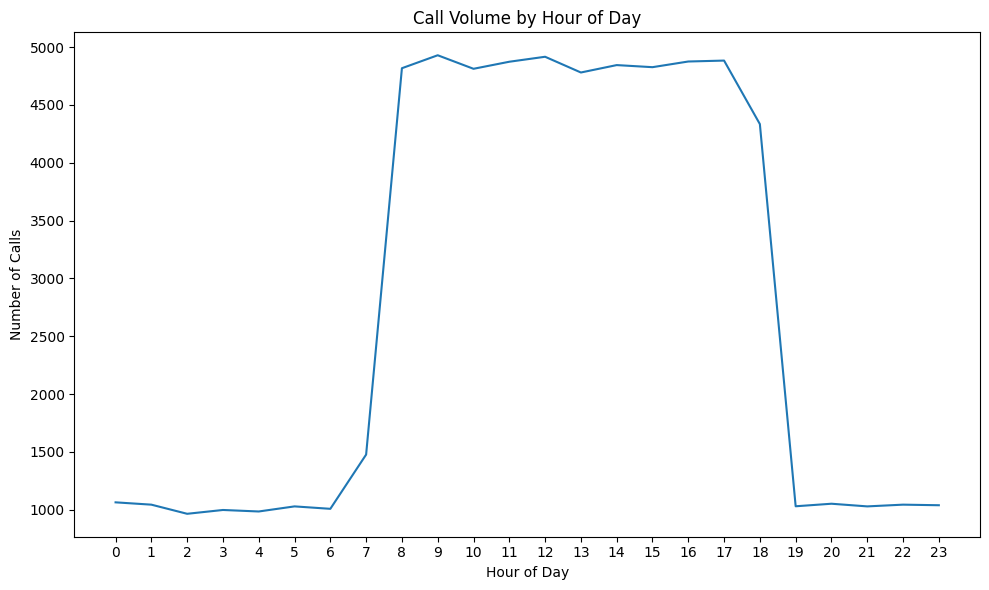

In [14]:
# Step 1: Add a new feature for the hour of the day when each call was made
merged_data['call_hour'] = merged_data['call_start_datetime'].dt.hour

# Step 2: Analyze call volumes by the hour of the day
call_volume_by_hour = merged_data.groupby('call_hour')['call_id'].count()

# Plot: Call Volume by Hour of the Day
plt.figure(figsize=(10, 6))
sns.lineplot(x=call_volume_by_hour.index, y=call_volume_by_hour.values)
plt.title("Call Volume by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Calls")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

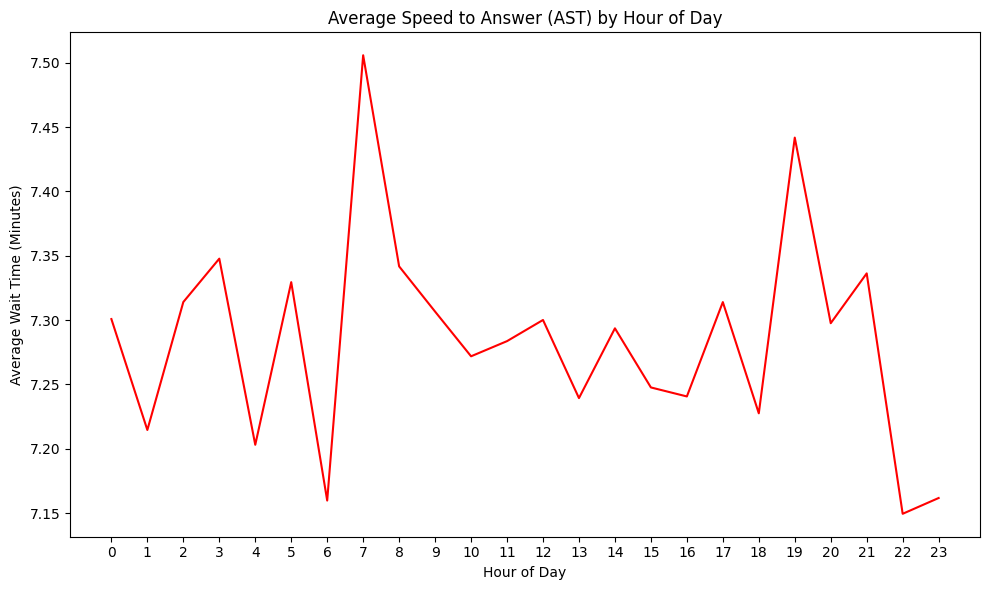

In [15]:
# Step 3: Analyze AST (Average Speed to Answer) by Hour of Day
ast_by_hour = merged_data.groupby('call_hour')['wait_time'].mean()

# Plot: AST by Hour of the Day
plt.figure(figsize=(10, 6))
sns.lineplot(x=ast_by_hour.index, y=ast_by_hour.values, color='red')
plt.title("Average Speed to Answer (AST) by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Wait Time (Minutes)")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()